<a href="https://colab.research.google.com/github/RamonCastill/food_101_cvision/blob/main/Transfer_learning_for_audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crear modelo de clasificacion de audio

In [ ]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"dbp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
google-cloud-aiplatform 1.70.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4

In [ ]:
!pip install --upgrade tensorflow tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

from sklearn.model_selection import train_test_split

### Cargar Yamnet


In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

## Funciones


In [ ]:
def load_wav_for_map(filename, label, fold):
  audio = load_wav_16k_mono(filename)
  if audio is None:
      return None
  return audio, label, fold

In [ ]:
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

In [ ]:

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [ ]:
def validate_wav_format(filename):
    """ Verifica que el formato del archivo WAV sea compatible """
    try:
        with open(filename, 'rb') as f:
            riff_chunk_size = int.from_bytes(f.read(4), byteorder='little')
            f.seek(12)
            format_chunk_size = int.from_bytes(f.read(4), byteorder='little')
            if format_chunk_size not in [16, 18]:
                return False
            f.seek(34)
            num_bits = int.from_bytes(f.read(2), byteorder='little')
            if num_bits != 16:
                return False
            return True
    except:
        return False

In [ ]:
@tf.function
def load_wav_16k_mono2(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    #file_contents = tf.io.read_file(filename)
    #wav, sample_rate = tf.audio.decode_wav(
    #      file_contents,
    #      desired_channels=1)
    #wav = tf.squeeze(wav, axis=-1)
    #sample_rate = tf.cast(sample_rate, dtype=tf.int64)


     # Verificar el tamaño del chunk de formato y su valor
    with tf.io.gfile.GFile(filename, 'rb') as f:
        riff_chunk_size = int.from_bytes(f.read(4), byteorder='little')
        f.seek(12)
        format_chunk_size = int.from_bytes(f.read(4), byteorder='little')
        audio_format = int.from_bytes(f.read(2), byteorder='little')
        f.seek(34)
        num_bits = int.from_bytes(f.read(2), byteorder='little')
        f.seek(20)
        audio_format_wav = int.from_bytes(f.read(2), byteorder='little')

    if audio_format != 16 and audio_format != 18:
        return 0


    if num_bits == False:
        #raise ValueError("Bad bits number for WAV: Expected 16, but got {}".format(num_bits))
        return False

    if audio_format_wav != 1:
        #raise ValueError("Bad format for WAV: Expected 1, but got {}".format(audio_format_wav))
        return False


    #wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return True

In [ ]:
def validate_data_format(dataframe, column_name):
  df = dataframe.copy()
  for filename in df[column_name]:
      if not load_wav_16k_mono2(filename):
          df.drop(df[df[column_name] == filename].index, inplace = True)

  return df


## Eleccion conjunto de datos para modelo

Ejecurtar solo una de las siguientes celdas, en funcion del conjunto de datos que se desee para entrenar un modelo

### Speaker recognition dataset

investigar como descargar en este link:
https://www.kaggle.com/datasets/vjcalling/speaker-recognition-audio-dataset

In [ ]:
!kaggle datasets download -d vjcalling/speaker-recognition-audio-dataset

Dataset URL: https://www.kaggle.com/datasets/vjcalling/speaker-recognition-audio-dataset
License(s): unknown
100% 3.64G/3.64G [01:05<00:00, 94.7MB/s]
100% 3.64G/3.64G [01:05<00:00, 60.2MB/s]


In [ ]:
!unzip speaker-recognition-audio-dataset.zip

Archive:  speaker-recognition-audio-dataset.zip
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_000.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_001.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_002.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_003.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_004.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_005.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_006.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_007.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_008.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_009.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_010.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_011.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_012.wav  
  inflating: 50_speakers_audio_data/Speaker0026/Speaker26_013.wav  


Abrir drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_data_path = "/content/drive/My Drive/mis_datasets/audios"
my_metadata_csv = "/content/drive/My Drive/mis_datasets/audio_metadata.csv"

my_data = pd.read_csv(my_metadata_csv)


my_data['File'] = my_data['Filename'].apply(lambda x: os.path.join(my_data_path, x))

my_data['Label'] = 'Speaker_Ramon'
my_data = my_data[['File', 'Label']]


train_df, temp_df = train_test_split(my_data, test_size=0.2, random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
train_df['Sets'] = 'Training'
val_df['Sets'] = 'Validation'
test_df['Sets'] = 'Test'
my_data = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

In [ ]:
my_data.head()

,File,Label,Sets
0,/content/drive/My Drive/mis_datasets/audios/ra...,Speaker_Ramon,Training
1,/content/drive/My Drive/mis_datasets/audios/ra...,Speaker_Ramon,Training
2,/content/drive/My Drive/mis_datasets/audios/ra...,Speaker_Ramon,Training
3,/content/drive/My Drive/mis_datasets/audios/ra...,Speaker_Ramon,Training
4,/content/drive/My Drive/mis_datasets/audios/ra...,Speaker_Ramon,Training


In [ ]:
data = []
DATASET_PATH = "/kaggle/input/speaker-recognition-audio-dataset/"
PATH = "./50_speakers_audio_data"
for i, subdir in enumerate(os.listdir(PATH)):
    if (subdir[-2:] != 'ta'):
        for i, file in enumerate(os.listdir(os.path.join(PATH, subdir))):
            data.append([os.path.join(PATH,subdir,file), ("Speaker_" + subdir[-2:])])

data = pd.DataFrame(data, columns=["File", "Label"])
data["Sets"] = "Training"
data.head()

,File,Label,Sets
0,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
1,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
2,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
3,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
4,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training


juntar ambos datasets

In [ ]:
data = pd.concat([data, my_data]).reset_index(drop=True)

In [ ]:
data.head()

,File,Label,Sets
0,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
1,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
2,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
3,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training
4,./50_speakers_audio_data/Speaker_0017/Speaker_...,Speaker_17,Training


In [ ]:
# Dividir el dataset en 80% training y 20% restante
train_df, temp_df = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42)

# Luego dividir el 20% restante en 50% validación y 50% prueba
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=42)

# Actualizar las etiquetas de "Sets"
train_df['Sets'] = 'Training'
val_df['Sets'] = 'Validation'
test_df['Sets'] = 'Test'

# Combinar todo en un solo DataFrame si lo necesitas
data = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

data.head()

,File,Label,Sets
0,./50_speakers_audio_data/Speaker_0025/Speaker_...,Speaker_25,Training
1,./50_speakers_audio_data/Speaker0041/Speaker00...,Speaker_41,Training
2,./50_speakers_audio_data/Speaker0026/Speaker26...,Speaker_26,Training
3,./50_speakers_audio_data/Speaker_0004/Speaker_...,Speaker_04,Training
4,./50_speakers_audio_data/Speaker_0006/Speaker_...,Speaker_06,Training


In [ ]:
data.groupby('Sets').count()

,File,Label
Sets,,
Test,277,277
Training,2208,2208
Validation,276,276


In [ ]:
def create_tf_dataset(df):
    filenames = df['File']
    targets = df['target']
    fold = df['File']
    ds = tf.data.Dataset.from_tensor_slices((filenames, targets, fold))
    ds = ds.map(load_wav_for_map)  # cargar los archivos WAV
    ds = ds.map(extract_embedding).unbatch()
    return ds

In [ ]:
my_classes = ['Speaker_29', 'Speaker_28', 'Speaker_23', 'Speaker_Ramon']
map_class_to_id = {'Speaker_29':0, 'Speaker_28':1, 'Speaker_23':2, 'Speaker_Ramon': 3}
data_filtered = data[data["Label"].isin(my_classes)]


# Aesgurarse de que los audios estan en el formato correcto ******************
data_filtered = validate_data_format(data_filtered, 'File')


class_id = data_filtered['Label'].apply(lambda name: map_class_to_id[name])
data_filtered = data_filtered.assign(target=class_id)

full_path = data_filtered['File']#.apply(lambda row: os.path.join(base_data_path, row))
data_filtered = data_filtered.assign(filename=full_path)

train_data = data_filtered[data_filtered['Sets'] == 'Training']
val_data = data_filtered[data_filtered['Sets'] == 'Validation']
test_data = data_filtered[data_filtered['Sets'] == 'Test']

train_ds = create_tf_dataset(train_data)
val_ds = create_tf_dataset(val_data)
test_ds = create_tf_dataset(test_data)
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column).cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(remove_fold_column).cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(remove_fold_column).cache().batch(32).prefetch(tf.data.AUTOTUNE)

#main_ds.element_spec

NameError: name 'data' is not defined

### Urbansound8k dataset para entrenar

In [ ]:
my_classes = ['dog_bark', 'car_horn', 'gun_shot']
map_class_to_id = {'dog_bark':0, 'car_horn':1, 'gun_shot':2}
UrbanSound8K_df_filtered = UrbanSound8K_df[UrbanSound8K_df["class"].isin(my_classes)]


# Aesgurarse de que los audios estan en el formato correcto ******************
UrbanSound8K_df_filtered = validate_data_format(UrbanSound8K_df_filtered, 'filepath')


class_id = UrbanSound8K_df_filtered['class'].apply(lambda name: map_class_to_id[name])
UrbanSound8K_df_filtered = UrbanSound8K_df_filtered.assign(target=class_id)

full_path = UrbanSound8K_df_filtered['filepath']#.apply(lambda row: os.path.join(base_data_path, row))
UrbanSound8K_df_filtered = UrbanSound8K_df_filtered.assign(filename=full_path)

UrbanSound8K_df_filtered.head(10)

filenames = UrbanSound8K_df_filtered['filename']
targets = UrbanSound8K_df_filtered['target']
folds = UrbanSound8K_df_filtered['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
#main_ds.element_spec

main_ds = main_ds.map(load_wav_for_map)
#main_ds.element_spec

main_ds = main_ds.map(extract_embedding).unbatch()
#main_ds.element_spec

cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

main_ds.element_spec

In [ ]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

In [ ]:
UrbanSound8K_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
UrbanSound8K_df.head()

In [ ]:
UrbanSound8K_df.groupby('class').slice_file_name.count()

In [ ]:
my_classes = ['dog_bark', 'car_horn', 'gun_shot']
map_class_to_id = {'dog_bark':0, 'car_horn':1, 'gun_shot':2}
UrbanSound8K_df_filtered = UrbanSound8K_df[UrbanSound8K_df["class"].isin(my_classes)]


# Aesgurarse de que los audios estan en el formato correcto ******************
UrbanSound8K_df_filtered = validate_data_format(UrbanSound8K_df_filtered, 'filepath')


class_id = UrbanSound8K_df_filtered['class'].apply(lambda name: map_class_to_id[name])
UrbanSound8K_df_filtered = UrbanSound8K_df_filtered.assign(target=class_id)

full_path = UrbanSound8K_df_filtered['filepath']#.apply(lambda row: os.path.join(base_data_path, row))
UrbanSound8K_df_filtered = UrbanSound8K_df_filtered.assign(filename=full_path)

UrbanSound8K_df_filtered.head(10)

filenames = UrbanSound8K_df_filtered['filename']
targets = UrbanSound8K_df_filtered['target']
folds = UrbanSound8K_df_filtered['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
#main_ds.element_spec

main_ds = main_ds.map(load_wav_for_map)
#main_ds.element_spec

main_ds = main_ds.map(extract_embedding).unbatch()
#main_ds.element_spec

cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

main_ds.element_spec

### esc-50 dataset para entrenar

In [ ]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [ ]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

In [ ]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

#filtered_pd.head(10)

filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
#main_ds.element_spec

main_ds = main_ds.map(load_wav_for_map)
#main_ds.element_spec

main_ds = main_ds.map(extract_embedding).unbatch()
#main_ds.element_spec

cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

main_ds.element_spec

## Creacion del modelo

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 526,852 (2.01 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)


Epoch 1/20
    448/Unknown 130s 264ms/step - accuracy: 0.8043 - loss: 0.5852

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


454/454 ━━━━━━━━━━━━━━━━━━━━ 152s 310ms/step - accuracy: 0.8052 - loss: 0.5823 - val_accuracy: 0.8845 - val_loss: 0.3617
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - accuracy: 0.8997 - loss: 0.3171 - val_accuracy: 0.9200 - val_loss: 0.2282
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9142 - loss: 0.2478 - val_accuracy: 0.9060 - val_loss: 0.2595
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9309 - loss: 0.1869 - val_accuracy: 0.8996 - val_loss: 0.2760
Epoch 5/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9298 - loss: 0.1804 - val_accuracy: 0.9119 - val_loss: 0.2428
Epoch 6/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9414 - loss: 0.1649 - val_accuracy: 0.9237 - val_loss: 0.2286
Epoch 7/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9423 - loss: 0.1568 - val_accuracy: 0.9280 - val_loss: 0.2006
Epoch 8/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9502 - loss: 0.1314 - val_accuracy: 0.929

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 244ms/step - accuracy: 0.9271 - loss: 0.3014
Loss:  0.263245165348053
Accuracy:  0.9301825761795044


test

In [ ]:
test_file_path = data_filtered[data_filtered['Label'] == 'Speaker_Ramon']['File'].values[0]

test_file_path = load_wav_16k_mono(test_file_path)

In [ ]:
# test data names
# dog_testing_wav_data
# cat_testing_wav_file
# thunder_testing_wav_file

scores, embeddings, spectrogram = yamnet_model(test_file_path)
result = my_model(embeddings).numpy()

mean_result = result.mean(axis=0)
probabilities = tf.nn.softmax(mean_result).numpy()
for class_name, probability in zip(my_classes, probabilities):
    print(f'Class: {class_name}, Probability: {probability * 100:.2f}%')

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

Class: Speaker_29, Probability: 0.00%
Class: Speaker_28, Probability: 0.00%
Class: Speaker_23, Probability: 0.08%
Class: Speaker_Ramon, Probability: 99.92%
The main sound is: Speaker_Ramon


save

## Guardar modelo completo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle):
        super(YamnetLayer, self).__init__()
        self.yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False)

    def call(self, inputs):
        # Asegúrate de que la entrada sea un tensor válido para YAMNet
        _, embeddings_output, _ = self.yamnet_layer(inputs)
        return embeddings_output

In [ ]:
saved_model_path = './speakers'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
#_, embeddings_output, _ = embedding_extraction_layer(input_segment)
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')

# Usa la capa personalizada para extraer los embeddings de YAMNet
yamnet_output = YamnetLayer(yamnet_model_handle)(input_segment)


serving_outputs = my_model(yamnet_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

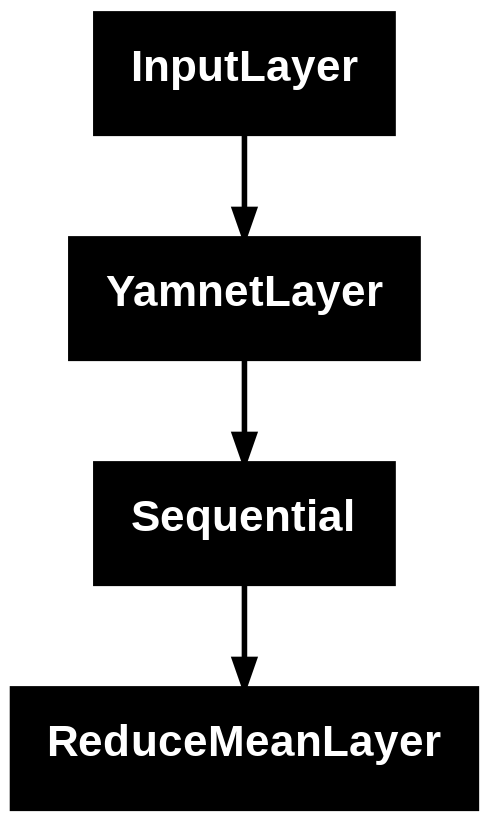

In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

OSError: SavedModel file does not exist at: ./speakers.keras/{saved_model.pbtxt|saved_model.pb}

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


./datasets/ESC-50-master/audio/5-172299-A-5.wav
Waveform values: [-1.0854422e-06  3.1059460e-06 -1.3652678e-06 ...  1.6882542e-01
  1.3804492e-01  5.8870625e-02]


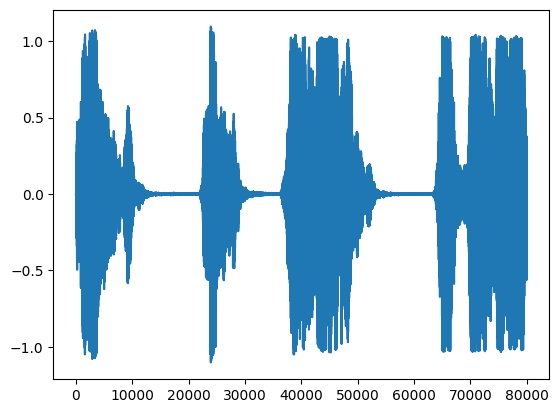

In [ ]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [ ]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Domestic animals, pets (0.5051152110099792)
[Your model] The main sound is: cat (0.9920514822006226)


In [ ]:
model_save_path = '/content/drive/My Drive/dogs_and_cats_yamnet_model/'
serving_model.save(model_save_path, include_optimizer=False)